In [1]:
%matplotlib inline
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import gym

Finished:
- Baseline BRS

TODO:
List of things to check:
- VARIABLES:
    - Random seed vs total_mean_reward(TMR)
    - N_ROLLOUTS vs TMR
    - TOTAL_STEPS vs TMR
    - b=2
    - alpha=1e-3 
    - std=1
    - v=1e-3
    - States norm (minmax)

COMPONENTS:
- sample number unsorted vs sorted by reward 
- rollouts

# Hyper Parameters and Ranges

In [2]:
# PARAMETERS

# Random seed 
SEED = 42
# Number of steps to wait until next update 
N_ROLLOUTS = 10
# Number of total steps of env simulation
TOTAL_STEPS = 1000
# Number of evaluation stapes 
EVAL_STEPS = 1000
#
ALPHA = 1e-3 
# STD for normal dist. for exploration noise
STD = 1
# Amount of noise we add (weight multiplyer)
V = 1e-3

# Parameters ranges
# (min, max, step)
SEED_RANGE = (0, 1024, 1)
TOTAL_STEPS_RANGE = (1, 1e+5, 1)
N_ROLLOUTS_RANGE = (0, TOTAL_STEPS_RANGE[1], 1)
ALPHA_RANGE = (0, 1, 1e-3)
STD_RANGE = (0, 1, 1e-3)
V_RANGE = (0, 1, 1e-3)


# Model
In all experiments will be used one type of model.

In [3]:
class Linear_model:
    def __init__(self, n_state, n_action): 
        # M stands for parameters of this model
        self.M = np.zeros((n_action, n_state))
        
    def __call__(self, state, v=0, noise=1):
        '''
            v - [0.,1.] controls how much noise we adding to our parameters
            noise - noise of same shape as M
        '''
        action = (self.M + v*noise) @ state
        return action

# Ablation study

How most simple version performs on basic envs?

In [4]:
class BaseRandomSearch:
    def __init__(self, n_state, n_action, std, v):
        self.policy = Linear_model(n_state,n_action)
        self.std = std
        self.v = v
        
        self.buffer = []
        
    def get_actions(self, state, is_train=False):
        if is_train:
            noise = np.random.normal(0, self.std, size=self.policy.M.shape)
            action_pos = self.policy(state,  self.v, noise)
            action_neg = self.policy(state, -self.v, noise)
            action_pos = self._remap_actions(action_pos)
            action_neg = self._remap_actions(action_neg)
            return action_pos, action_neg, noise
        else:
            action = self.policy(state)
            return self._remap_actions(action)
    def learn(self):
        update = np.zeros_like(self.policy.M)
        for step in self.buffer:
            if self.v == 0:
                update = 0
            else:
                update += ((step[-2] - step[-1]) * step[-3]) / self.v
        
        self.policy.M = self.policy.M + update  
        
        self.buffer = []
        
    def remember(self, memory):
        self.buffer.append(memory)
        
    def _remap_actions(self, action):
        return 2 * np.tanh(action)
            
        

Train BRS

In [5]:
def train(env, model, STD, V):
    np.random.seed(SEED)
    env.seed(SEED)
    observation = env.reset()

    #REWARDS = []
    for step in range(TOTAL_STEPS):
        #t_reward = 0
        for ro in range(N_ROLLOUTS):
            pos_action, neg_action, noise = model.get_actions(observation, is_train=True)
            pos_observation, pos_reward, pos_done, pos_info = env.step(pos_action)
            neg_observation, neg_reward, neg_done, neg_info = env.step(neg_action)

            model.remember([pos_action[0], neg_action[0], noise, pos_reward, neg_reward])
            #t_reward += (pos_reward + neg_reward)/2

            coin = np.random.rand() 
            if coin < 0.33:
                observation = env.reset()
            elif 0.33 < coin < 0.66:
                observation = pos_observation 
            elif coin > 0.66:
                observation = neg_observation
        model.learn()
        #REWARDS.append(t_reward)

    env.close()
    return model

In [6]:
def evaluate(env, model, SEED=SEED, EVAL_STEPS=EVAL_STEPS):
    np.random.seed(SEED)
    env.seed(SEED)
    observation = env.reset()

    score = 0

    for step in range(EVAL_STEPS):
        action = model.get_actions(observation)
        observation, reward, done, info = env.step(action)

        score += reward

        if done:
            observation = env.reset()

    env.close()
    return score

Now we will check if std of exploration noise and it weight have any impact on model performance.

In [7]:
STD_RANGE = (1e-3, 1, 8e-2)
V_RANGE = (1e-3, 1, 8e-2)

env = gym.make('Pendulum-v1', g=9.82)
n_action = 1 
n_state = 3

monitor_sml = []
saved_polices = []
for std in tqdm(np.arange(*STD_RANGE)):
    for v in np.arange(*V_RANGE):
        model = BaseRandomSearch(n_state, n_action, std=std, v=v)
        
        trained_model = train(env, model, std, v)
        score = evaluate(env, trained_model)
        monitor_sml.append([std, v, score])
        saved_polices += [model.policy.M]
monitor_sml = np.array(monitor_sml)

100%|███████████████████████| 13/13 [06:28<00:00, 29.92s/it]


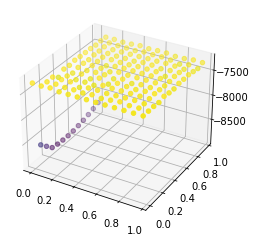

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(monitor_sml[:,0], monitor_sml[:,1], monitor_sml[:,2], c=monitor_sml[:,2], cmap='viridis')
plt.show()

In [9]:
print('Sample of learned polices:')
saved_polices[:10]

Sample of learned polices:


[array([[ 50.02662545,   6.52832292, -53.80112665]]),
 array([[ 0.39109903, -0.01340319, -1.18940405]]),
 array([[ 0.30179134, -0.16097617, -0.68581453]]),
 array([[ 0.24257747, -0.12709247, -0.48360079]]),
 array([[ 0.22016752, -0.086444  , -0.36975046]]),
 array([[ 0.20175881, -0.03610265, -0.30087236]]),
 array([[ 0.1814356 , -0.02541943, -0.25927804]]),
 array([[ 0.16285868, -0.01828054, -0.22596956]]),
 array([[ 0.14639699, -0.0147131 , -0.20006588]]),
 array([[ 0.1316422 , -0.01221031, -0.18035104]])]

F

In [11]:
STD_RANGE = (1e-3, 10, 1)
V_RANGE = (1e-3, 10, 1)

env = gym.make('Pendulum-v1', g=9.82)
n_action = 1 
n_state = 3

monitor_big = []
saved_polices = []
for std in tqdm(np.arange(*STD_RANGE)):
    for v in np.arange(*V_RANGE):
        
        model = BaseRandomSearch(n_state, n_action, std=std, v=v)
        
        trained_model = train(env, model, std, v)
        score = evaluate(env, trained_model)
        monitor_big.append([std, v, score])
        saved_polices.append(model.policy.M)
monitor_big = np.array(monitor_big)

100%|███████████████████████| 10/10 [04:01<00:00, 24.11s/it]


In [15]:
print('Sample of learned polices:')
saved_polices[:10]

Sample of learned polices:


[array([[ 50.02662545,   6.52832292, -53.80112665]]),
 array([[ 0.0951701 , -0.00505806, -0.13512594]]),
 array([[ 0.04525386, -0.00113757, -0.06784552]]),
 array([[ 0.02994372,  0.00030729, -0.04406158]]),
 array([[ 0.02243102,  0.0008831 , -0.03244076]]),
 array([[ 0.01786125,  0.00108983, -0.02540097]]),
 array([[ 0.014789  ,  0.00114384, -0.02069149]]),
 array([[ 0.01262719,  0.00115561, -0.01731582]]),
 array([[ 0.01102378,  0.00114803, -0.01477225]]),
 array([[ 0.00977976,  0.00113444, -0.01278657]])]

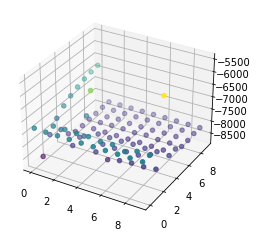

In [16]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(monitor_big[:,0], monitor_big[:,1], monitor_big[:,2], c=monitor_big[:,2])
plt.show()

In [34]:
monitor_big[:10]

array([[ 1.00000000e-03,  1.00000000e-03, -7.30127311e+03],
       [ 1.00000000e-03,  1.00100000e+00, -8.70186558e+03],
       [ 1.00000000e-03,  2.00100000e+00, -8.05049249e+03],
       [ 1.00000000e-03,  3.00100000e+00, -7.62288425e+03],
       [ 1.00000000e-03,  4.00100000e+00, -7.35363134e+03],
       [ 1.00000000e-03,  5.00100000e+00, -7.17295301e+03],
       [ 1.00000000e-03,  6.00100000e+00, -7.03771923e+03],
       [ 1.00000000e-03,  7.00100000e+00, -6.92974316e+03],
       [ 1.00000000e-03,  8.00100000e+00, -6.86038859e+03],
       [ 1.00000000e-03,  9.00100000e+00, -6.80188293e+03]])

Interesting pattern can be seen with `std` really small and as `v` grows, reward grows as well.  
Based on that I will fix `std = 1e-3` for next experiments.

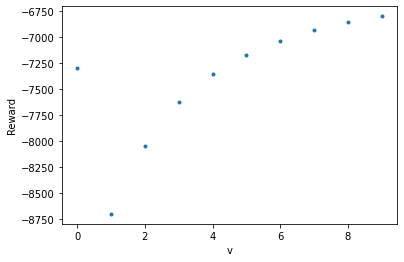

In [39]:
# std, v, score
plt.plot(monitor_big[:10,1], monitor_big[:10,2], '.')
plt.ylabel('Reward')
plt.xlabel('v')
plt.show()

Text(0.5, 1.0, 'Reward: 1-small values; 2-big values')

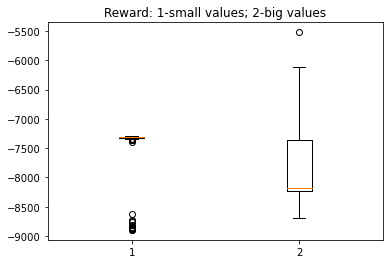

In [41]:
fig, ax = plt.subplots()
D = [monitor_sml[:,2], monitor_big[:,2]]
b = ax.boxplot(D)
plt.title('Reward: 1-small values; 2-big values')

Conclusion on this BRS baseline:  
no matter of parameters model sees same states and converges to same susboptimal state.

## BRS with random sampling


In [50]:
class BRS_RS:
    def __init__(self, n_state, n_action, std, v, n_samples):
        self.policy = Linear_model(n_state,n_action)
        self.std = std
        self.v = v
        self.n_samples = n_samples
        
        self.buffer = []
        
    def get_actions(self, state, is_train=False):
        if is_train:
            noise = np.random.normal(0, self.std, size=self.policy.M.shape)
            action_pos = self.policy(state,  self.v, noise)
            action_neg = self.policy(state, -self.v, noise)
            action_pos = self._remap_actions(action_pos)
            action_neg = self._remap_actions(action_neg)
            return action_pos, action_neg, noise
        else:
            action = self.policy(state)
            return self._remap_actions(action)
        
    def learn(self):
        update = np.zeros_like(self.policy.M)
        
        
        
        buffer_idxs = np.random.choice(np.arange(len(self.buffer)), self.n_samples)
        buffer = np.array(self.buffer)[buffer_idxs]
        
        for step in buffer:
            if self.v == 0:
                update = 0
            else:
                update += ((step[-2] - step[-1]) * step[-3]) / self.v
        
        self.policy.M = self.policy.M + update  
        
        self.buffer = []
        
    def remember(self, memory):
        self.buffer.append(memory)
        
    def _remap_actions(self, action):
        return 2 * np.tanh(action)
            

In [51]:
STD = 1e-3
V_RANGE = (1, 10, 1)
N_SAMPLE_RANGE = (1, N_ROLLOUTS, 1)

env = gym.make('Pendulum-v1', g=9.82)
n_action = 1 
n_state = 3

monitor_rs = []
saved_polices = []
for n_samples in tqdm(np.arange(*N_SAMPLE_RANGE)):
    for v in np.arange(*V_RANGE):
        model = BRS_RS(n_state, n_action, std=std, v=v, n_samples=n_samples)
        
        trained_model = train(env, model, STD, v)
        score = evaluate(env, trained_model)
        
        monitor_rs.append([n_samples, v, score])
        saved_polices += [model.policy.M]

monitor_rs = np.array(monitor_rs)

  0%|                                 | 0/9 [00:00<?, ?it/s]/tmp/ipykernel_329248/1444988081.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  buffer = np.array(self.buffer)[buffer_idxs]
100%|█████████████████████████| 9/9 [03:17<00:00, 21.90s/it]


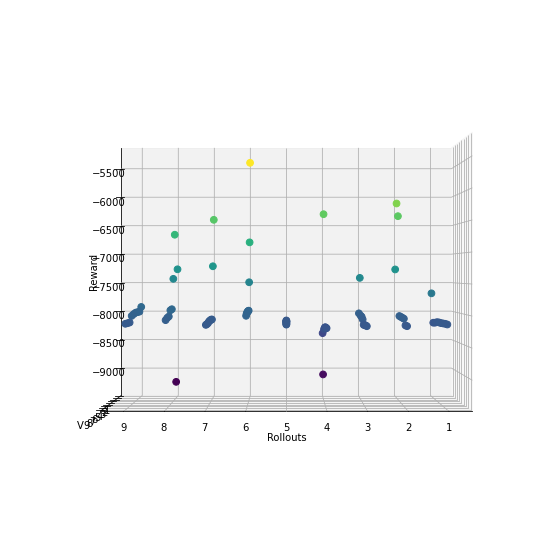

In [88]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(monitor_rs[:,0], monitor_rs[:,1], monitor_rs[:,2], c=monitor_rs[:,2], s=45, alpha=1)
ax.view_init(0, 90)
ax.set_xlabel('Rollouts')
ax.set_ylabel('V')
ax.set_zlabel('Reward')
# ax.plot(monitor_rs[:,0], monitor_rs[:,1], monitor_rs[:,2], color='k')
plt.show()


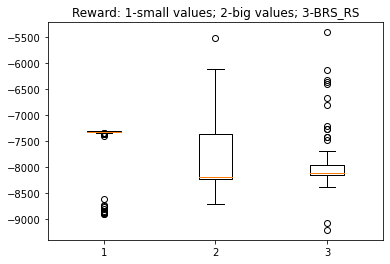

In [89]:
fig, ax = plt.subplots()
D = [monitor_sml[:,2], monitor_big[:,2], monitor_rs[:,2]]
b = ax.boxplot(D)
plt.title('Reward: 1-small values; 2-big values; 3-BRS_RS')
plt.show()

Conclusion for random sampling:  
it worth performance so far 

## BRS Sorted by reward trajectories 

# Development

In [4]:
class ARS:
    def __init__(self, n_state, n_action, b=2, alpha=1e-3, std=1, v=1e-3,
                state_high=None, state_low=None):
        self.policy = Linear_model(n_state, n_action)
        self.buffer = []
        self.alpha = alpha
        self.std = std
        self.v = v
        # b - number of b top-performing directions 
        self.b = b
        
        self.state_low = state_low 
        self.state_high = state_high
        
    def learn(self):
        # sort noise permutations by reward they achive, 
        # and select only high reward ones
        b_buffer = self.sort_directions()
        
        reward_std = b_buffer[:, -2:].std()
        norm = self.alpha / (self.b * reward_std)
        
        reward_sum = 0
        for step in b_buffer:
            # ( R+ - R- ) * noise
            reward_sum += (step[-2] - step[-1]) * step[-3]
    
        self.policy.M = self.policy.M + (norm * reward_sum)
        
        # reset buffer 
        self.buffer = []
    
    def sort_directions(self):
        buffer = np.array(self.buffer, dtype=object)
        b_rewards = buffer[:, -2:].sum(-1)
        
        # idxs from low to high
        b_idxs = np.argsort(b_rewards)
        b_buffer = buffer[b_idxs][-self.b:]
        
        # print(buffer[b_idxs][:-self.b][:,-2:].mean(), buffer[b_idxs][-self.b:][:,-2:].mean())
        return b_buffer
    
    def get_actions(self, state, is_train=False):
        if not self.state_high is None:
            # MINMAX NORM {value - min}/{max - min}
            state = (state - self.state_low)/(self.state_high - self.state_low)
            
        if is_train:
            noise = np.random.normal(0,self.std, size=self.policy.M.shape)
            pos_action = self.policy(state,  self.v, noise)
            neg_action = self.policy(state, -self.v, noise)
            
            pos_action = self._remap_actions(pos_action)
            neg_action = self._remap_actions(neg_action)
            return pos_action, neg_action, noise
        else:
            action = self.policy(state)
            return self._remap_actions(action)
            
    
    def remember(self, memory):
        self.buffer.append(memory)
        
    def _remap_actions(self, action):
        return 2 * np.tanh(action)
    


In [5]:
import gym
env = gym.make('Pendulum-v1', g=9.82)
env.seed(SEED)
observation = env.reset()

state_high = env.observation_space.high
state_low = env.observation_space.low
model = ARS(3, 1, b=N_ROLLOUTS, std=1, 
            state_low=state_low, state_high=state_high)

REWARDS = []
t_reward = 0
for step in tqdm(range(TOTAL_STEPS)):
    #env.render()
    
    for ro in range(N_ROLLOUTS):
        pos_action, neg_action, noise = model.get_actions(observation, is_train=True)
        pos_observation, pos_reward, pos_done, pos_info = env.step(pos_action)
        neg_observation, neg_reward, neg_done, neg_info = env.step(neg_action)

        model.remember([pos_action[0], neg_action[0], noise, pos_reward, neg_reward])
        t_reward += (pos_reward + neg_reward)/2
        observation = env.reset()
        #observation = pos_observation if np.random.rand()>0.5 else neg_observation
    
    # if (pos_done or neg_done):
        
        
    # if (step % N_ROLLOUTS == 0 and step != 0):
    model.learn()
    REWARDS.append(t_reward)
    t_reward = 0
    
env.close()

100%|██████████| 100/100 [00:00<00:00, 1988.18it/s]


In [6]:
model.policy.M

array([[ 0.00088557,  0.00168218, -0.00120841]])

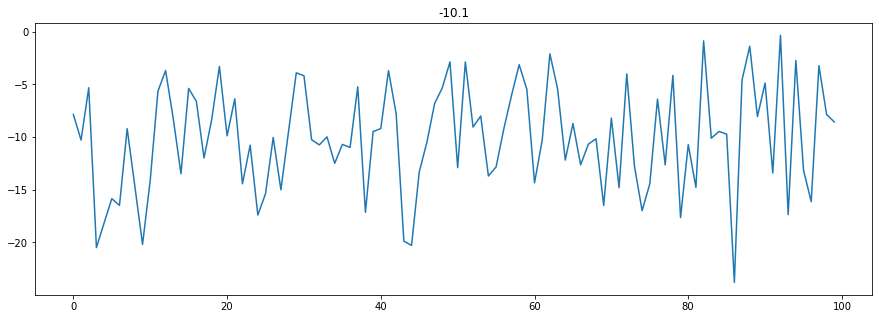

In [7]:
plt.figure(figsize=(15,5))
plt.plot(REWARDS)
plt.title(np.mean(REWARDS).round(1))
plt.show()

In [12]:
import pandas as pd

In [8]:
meta_data_collector = {''}



In [9]:
env = gym.make('Pendulum-v1', g=9.81)

np.random.seed(SEED)
env.seed(SEED)

observation = env.reset()

state_high = env.observation_space.high
state_low = env.observation_space.low


In [10]:
# EVALUATION
# env = gym.make('Pendulum-v1', g=9.82)
# observation = env.reset()

score = 0
for step in tqdm(range(EVAL_STEPS)):
    #env.render()
    
    action = model.get_actions(observation)
    observation, reward, done, info = env.step(action)
    
    score += reward
    
    if done:
        observation = env.reset()
        
env.close()
print(score)

100%|██████████| 1000/1000 [00:00<00:00, 18524.20it/s]

-6117.20509834359


In [1]:
# model = ARS(3, 1, b=N_ROLLOUTS, std=1, 
#             state_low=state_low, state_high=state_high)

# REWARDS = []
# t_reward = 0
# for step in tqdm(range(TOTAL_STEPS)):
#     #env.render()
    
#     for ro in range(N_ROLLOUTS):
#         pos_action, neg_action, noise = model.get_actions(observation, is_train=True)
#         pos_observation, pos_reward, pos_done, pos_info = env.step(pos_action)
#         neg_observation, neg_reward, neg_done, neg_info = env.step(neg_action)

#         model.remember([pos_action[0], neg_action[0], noise, pos_reward, neg_reward])
#         t_reward += (pos_reward + neg_reward)/2
#         #observation = env.reset()
#         observation = pos_observation if np.random.rand()>0.5 else neg_observation

#     model.learn()
#     REWARDS.append(t_reward)
#     t_reward = 0
    
# env.close()

In [1]:
# model.policy(np.array([1,1,0]))